## Go to each website listed and find key words and topics

in the DISASTER_RECOVERY_State_Emergency_Management_Office_Contacts file 


In [1]:
import requests
from bs4 import BeautifulSoup
from collections import Counter
import os
import csv
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
import re
import math
from textblob import TextBlob as tb
import networkx as nx
# import linkcom
import seaborn as sns
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
%matplotlib inline

/Users/rkfische/Library/Python/3.10/lib/python/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
import tabula

In [26]:
# from https://towardsdatascience.com/scraping-table-data-from-pdf-files-using-a-single-line-in-python-8607880c750

file1 = 'DISASTER_RECOVERY_State_Emergency_Management_Office_Contacts.pdf'
tabula.convert_into(file1, "output.csv", output_format="csv", pages='all')
df = pd.read_csv('output.csv')
em_df = df.dropna()

Got stderr: Aug 24, 2023 6:47:56 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider loadDiskCache
Aug 24, 2023 6:47:56 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>
Aug 24, 2023 6:47:56 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider addTrueTypeFont
java.io.FileNotFoundException: /Library/Fonts/georgia-pro.ttf (Permission denied)
	at java.io.RandomAccessFile.open0(Native Method)
	at java.io.RandomAccessFile.open(RandomAccessFile.java:316)
	at java.io.RandomAccessFile.<init>(RandomAccessFile.java:243)
	at org.apache.fontbox.ttf.BufferedRandomAccessFile.<init>(BufferedRandomAccessFile.java:88)
	at org.apache.fontbox.ttf.RAFDataStream.<init>(RAFDataStream.java:63)
	at org.apache.fontbox.ttf.TTFParser.parse(TTFParser.java:84)
	at org.apache.pdfbox.pdmodel.font.FileSystemFontProvider.addTrueTypeFont(FileSystemFontProvider.java:657)
	at org.apache.pdfbox.pdmodel.font.FileSystemFontProvider.scanFonts(FileSystemFontProvider.java:379)
	at org.apache.pdfbox.pdmod

In [110]:
df = pd.read_csv('DISASTER_RECOVERY_State_Emergency_Management_Office_Contacts.csv')
df = df.set_index('State')
em_df = df.dropna()

In [111]:
em_df.columns

Index(['Link to Emergency Management'], dtype='object')

In [112]:
em_df.head()

,Link to Emergency Management
State,
Alabama,http://ema.alabama.gov/
Alaska,https://akpreparedness.com/
Arizona,https://dema.az.gov/
Arkansas,http://www.adem.arkansas.gov/
California,https://www.caloes.ca.gov/


In [29]:
def findlinks(html2):
    while True:
        try:
           r = requests.get(html2, allow_redirects=True,timeout = (2, 5))
           r.raise_for_status()
        except requests.exceptions.RequestException as e: 
           return"" 
        if r.status_code == 200:
            break # Exit loop if status is valid
        else:
            return ""
        #except HTTPError as http_err:
            #print(f'HTTP error occurred: {http_err}')  # Python 3.6
            #return""
        #except Exception as err:
            #print(f'Other error occurred: {err}')  # Python 3.6
            #return"" 
    sitelinks =[]
    soup = BeautifulSoup(r.text, 'html.parser')
    
    foundUrls = Counter([link["href"] for link in soup.find_all("a", href=lambda href: href and href.startswith("h"))])
    foundUrls = foundUrls.most_common()
    for item in foundUrls:
        #print ("%s: %d" % (item[0], item[1]))
        sitelinks.append(item[0])
    return sitelinks

In [30]:
from requests.exceptions import HTTPError
def cleanMe2(html):
    try:
        #first element being a connect timeout and the second being a read timeout
        r = requests.get(html, allow_redirects = True,timeout = (2, 5))
        # If the response was successful, no Exception will be raised
        r.raise_for_status()
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')  # Python 3.6
    except Exception as err:
        print(f'Other error occurred: {err}')  # Python 3.6
        return"" 
    #else:
        #print('Success!')
    soup = BeautifulSoup(r.content, 'lxml')
    
    for script in soup(["script", "style"]): # remove all javascript and stylesheet code
        script.extract()
    # get text
    text = soup.get_text()
    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())   
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    return text 

In [31]:
def wordsToList(strn):
    L = strn.split()
    cleanL = []
    abc = 'abcdefghijklmnopqrstuvwxyz'
    ABC = abc.upper()
    letters = abc + ABC
    for e in L:
        word = ''
        for c in e:
            if c in letters:
                word += c
        if word != '':
            cleanL.append(word.lower())
    return cleanL

In [32]:
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

In [35]:
em_df.iat[1, 3] 

'http://www.ak-prepared.com/'

In [115]:



wordcount_df = pd.DataFrame(index = np.arange(3000), columns = ['Org', 'Word'])
#words = []
#word_list = []
count = 0
# For every partner/child website in the parent/CEC dataframe  
for i in df.index:
    # start with a clean list of words
    #del words[:]
    #del word_list[:]
    words = []
    word_list = []
    txt = "" 
    
    # find the links within the partner website
    partnerlinks = findlinks(em_df['Link to Emergency Management'][i])
    print(i)  # track script progress
    
    # get the text from every link in the partner's website 
    for y in partnerlinks:
        txt += cleanMe2(y)
    
    # convert the text into words and subtract the common words
    words = wordsToList(txt)
    common_words = ('and','a', 'the', 'from', 'in', 'an', 'of', 'to', 'is', 
                    'for', 'that', 'has', 'on', 'you', 'your', 'youre', 
                    'are', 'or', 'as', 'at', 'by', 'about', 'this',
                    'be', 'other', 'home', 'their', 'up', 'its',
                    'our', 'information', 'twitter', 'undo', 'with', 'us', 'we', 'new', 'close', 'use', 
                    'all', 'more', 'will', 'tweet', 'https', 'n', 'r', 'f', 'image', 'q',
                    'than','was', 'he', 'she', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 
                    'sep', 'oct', 'nov', 'dec', 'i', 'retweet', 'retweeted', 'were', 'but', 'opens',
                    'have', 'play', 'nextplay', 'search', 'ago', 'duragettion', 'views', 'seconds', 'can' ,'it',
                    'get', 'th', 'fax', 'de', 'tge', 'fh', 'w', 'u' , 'into'
                   )

    words = [x for x in words if x not in common_words]
    #words [y for y in words if y not in stopwords.words()]  #requires: from nltk.corpus import stopwords
    
    # count the words and make a list of the most common words
    word_list = Counter(words)
    word_list = word_list.most_common(200) 
    #print(word_list)

    word_text = ""
    for word, nbr in word_list:
        word_text += word
        word_text += " "
    
    wordcount_df["Word"][count]= word_text
    wordcount_df["Org"][count]= i
    count +=1
    
#drop the values at the end of the table and print
wordcount_df = wordcount_df.dropna()
print(count)
wordcount_df.set_index("Org")
print(wordcount_df)

Alabama


/Users/rkfische/Library/Python/3.10/lib/python/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


Other error occurred: HTTPSConnectionPool(host='www.nws.noaa.gov', port=443): Read timed out. (read timeout=5)
HTTP error occurred: 404 Client Error: Not Found for url: https://www.servealabama.gov/governor-s-emergency-relief-fund
HTTP error occurred: 404 Client Error: Not Found for url: https://www.baronweather.com/alabamasaftnet/
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.noaa.gov/
HTTP error occurred: 403 Client Error: Forbidden for url: https://www.tva.com/Energy/Our-Power-System/Nuclear/Browns-Ferry-Nuclear-Plant
HTTP error occurred: 404 Client Error: Not Found for url: https://www.southerncompany.com/about-us/our-business/southern-nuclear/home.cshtml
HTTP error occurred: 404 Client Error: Not Found for url: https://www.sba.gov/loans-grants/see-what-sba-offers/sba-loan-programs/disaster-loans/apply-disaster-loan
HTTP error occurred: 404 Client Error: Not Found for url: https://gema.georgia.gov/Pages/default.aspx
Other error occurred: Invalid URL 'http://

Other error occurred: HTTPSConnectionPool(host='dod.hawaii.gov', port=443): Read timed out. (read timeout=5)
HTTP error occurred: 404 Client Error: Not Found for url: https://dod.hawaii.gov/hiema/contact-us/about-us/
Other error occurred: HTTPSConnectionPool(host='dod.hawaii.gov', port=443): Read timed out. (read timeout=5)
Idaho
HTTP error occurred: 404 Client Error: Not Found for url: https://www.csepptemplate.com/id/default.aspx
HTTP error occurred: 404 Client Error: Not Found for url: https://www.youtube.com/UCslRcCg94nzTgTjCuNayMNw
Illinois
Other error occurred: HTTPSConnectionPool(host='home.treasury.gov', port=443): Read timed out. (read timeout=5)
Indiana
HTTP error occurred: 500 Server Error: Internal Server Error for url: https://share.dhs.gov/inbeoc
Iowa
Other error occurred: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Kansas
Kentucky
Louisiana
Maine
Maryland
HTTP error occurred: 406 Client Error: Not Acceptable for url: http:

Other error occurred: HTTPSConnectionPool(host='dps.sd.gov', port=443): Read timed out. (read timeout=5)
Other error occurred: HTTPSConnectionPool(host='dps.sd.gov', port=443): Read timed out. (read timeout=5)
Other error occurred: HTTPSConnectionPool(host='dps.sd.gov', port=443): Read timed out. (read timeout=5)
Other error occurred: HTTPSConnectionPool(host='dps.sd.gov', port=443): Read timed out. (read timeout=5)
Other error occurred: HTTPSConnectionPool(host='dps.sd.gov', port=443): Read timed out. (read timeout=5)
Other error occurred: HTTPSConnectionPool(host='dps.sd.gov', port=443): Read timed out. (read timeout=5)
Other error occurred: HTTPSConnectionPool(host='dps.sd.gov', port=443): Read timed out. (read timeout=5)
Other error occurred: HTTPSConnectionPool(host='dps.sd.gov', port=443): Read timed out. (read timeout=5)
Other error occurred: HTTPSConnectionPool(host='dps.sd.gov', port=443): Read timed out. (read timeout=5)
Other error occurred: HTTPSConnectionPool(host='dps.sd.

HTTP error occurred: 403 Client Error: Forbidden for url: https://vem.vermont.gov/programs/rerp/notifications
Virginia
Washington
West Virginia
HTTP error occurred: 403 Client Error: Forbidden for url: https://hsin.dhs.gov/
Other error occurred: HTTPSConnectionPool(host='www.governor.wv.gov', port=443): Max retries exceeded with url: /Pages/default.aspx (Caused by SSLError(CertificateError("hostname 'www.governor.wv.gov' doesn't match either of '*.wvinteractive.com', 'wvinteractive.com'")))
HTTP error occurred: 404 Client Error: Not Found for url: https://www.youtube.com/user/wvdhsem
Wisconsin
HTTP error occurred: 403 Client Error: Forbidden for url: https://cdp.dhs.gov/
HTTP error occurred: 403 Client Error: Forbidden for url: https://cdp.dhs.gov/FEMASID
HTTP error occurred: 403 Client Error: Forbidden for url: https://sertc.org/
HTTP error occurred: 403 Client Error: Forbidden for url: https://teex.org/
HTTP error occurred: 404 Client Error: Not Found for url: https://wem.wi.gov/haza

In [116]:
wordcount_df = wordcount_df.drop(wordcount_df[wordcount_df.Word == ''].index)
print(wordcount_df)
wordcount_df.to_csv("wordcount_df.csv")

                     Org                                               Word
0                Alabama  qe h p c z o e b t g x v k obj j s endobj d m ...
1                 Alaska  forbidden video access page vimeo emergency re...
2                Arizona  state arizona policy resources web agency azgo...
3               Arkansas  training commander troop state area forms crim...
4             California  california emergency state oes cal office serv...
5               Colorado  colorado report status daily emergency fire st...
6            Connecticut  state connecticut not ctgov ct facebook depart...
7               Delaware  link delaware contact state website date poste...
8   District of Columbia  fy pdf plan par dc district public mayor servi...
9                Florida  department management emergency division flori...
10               Georgia  georgia state georgiagov department office web...
11                Hawaii  emergency hawaii state proclamations mitigatio...
12          

In [117]:
wordcount_df = pd.read_csv('wordcount_df.csv')

In [118]:
wordcount_df = wordcount_df.dropna()

In [119]:
docs = wordcount_df['Word'].tolist()

In [120]:
docs

['qe h p c z o e b t g x v k obj j s endobj d m l y stream endstream alabama emergency weather august pm typepage management fema state cdefghijstuvwxyzcdefghijstuvwxyz plan cdt assistance extgstatefontprocsetpdftextrotate ready disaster mitigation public jp report county agency program ke pk heat al ema if email am severe go jz issued rbr aqaqbrbr storm jfif aqaqb local jh preparedness business kgbybgnptutcrbkstq cqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq resources office hazard extreme services until rr xn ww qk contact shelter governor gj winter national training system service declaration governors zj power do events eo no response hurricanes qq soe ih so how po not incident gy safety ftypjp jpxbjpx rreq ihdr colr gw pe disasters warning my help re alerts follow yo tornadoes planning storms grant zh noaa clanton website zo oq qh kids vc ie act hq ae jph emergencies rq situation tw qj content operations wk vf ii thunderstorms alz cy links statement bp ep pp lk st hh pt rm 

In [121]:
from sklearn.feature_extraction.text import CountVectorizer
Cvect = CountVectorizer(analyzer='word')
tf_matrix = Cvect.fit_transform(docs)
tf_df = pd.DataFrame(tf_matrix.toarray(), columns = Cvect.get_feature_names(), index = wordcount_df['Org'])
print(tf_df)

                      ab  abbott  abbottposted  abduction  able  aboutnews  \
Org                                                                          
Alabama                0       0             0          0     0          0   
Alaska                 0       0             0          0     0          0   
Arizona                0       0             0          0     0          0   
Arkansas               0       0             0          0     0          0   
California             0       0             0          0     0          1   
Colorado               0       0             0          0     0          0   
Connecticut            0       0             0          0     0          0   
Delaware               0       0             0          0     0          0   
District of Columbia   0       0             0          0     0          0   
Florida                0       0             0          0     0          0   
Georgia                0       0             0          0     0 

/Users/rkfische/Library/Python/3.10/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(analyzer='word')
tfidf_matrix = vect.fit_transform(docs)
tf_idf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names(), index = wordcount_df['Org'])
print(tf_idf_df)

                            ab    abbott  abbottposted  abduction      able  \
Org                                                                           
Alabama               0.000000  0.000000      0.000000   0.000000  0.000000   
Alaska                0.000000  0.000000      0.000000   0.000000  0.000000   
Arizona               0.000000  0.000000      0.000000   0.000000  0.000000   
Arkansas              0.000000  0.000000      0.000000   0.000000  0.000000   
California            0.000000  0.000000      0.000000   0.000000  0.000000   
Colorado              0.000000  0.000000      0.000000   0.000000  0.000000   
Connecticut           0.000000  0.000000      0.000000   0.000000  0.000000   
Delaware              0.000000  0.000000      0.000000   0.000000  0.000000   
District of Columbia  0.000000  0.000000      0.000000   0.000000  0.000000   
Florida               0.000000  0.000000      0.000000   0.000000  0.000000   
Georgia               0.000000  0.000000      0.0000

/Users/rkfische/Library/Python/3.10/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [123]:
tf_idf_df.to_csv("all3matrix_idf_df.csv")

In [124]:
def cosine_similarity(vector1, vector2):
    dot_product = sum(p*q for p,q in zip(vector1, vector2))
    magnitude = math.sqrt(sum([val**2 for val in vector1])) * math.sqrt(sum([val**2 for val in vector2]))
    if not magnitude:
        return 0
    return dot_product/magnitude

In [125]:
cos_sim1 = cosine_similarity(tf_idf_df.iloc[0], tf_idf_df.iloc[1])
cos_sim2 = cosine_similarity(tf_idf_df.iloc[0], tf_idf_df.iloc[2])
cos_sim3 = cosine_similarity(tf_idf_df.iloc[0], tf_idf_df.iloc[3])
print(wordcount_df)
print(cos_sim1, cos_sim2, cos_sim3)

    Unnamed: 0                   Org  \
0            0               Alabama   
1            1                Alaska   
2            2               Arizona   
3            3              Arkansas   
4            4            California   
5            5              Colorado   
6            6           Connecticut   
7            7              Delaware   
8            8  District of Columbia   
9            9               Florida   
10          10               Georgia   
11          11                Hawaii   
12          12                 Idaho   
13          13              Illinois   
14          14               Indiana   
15          15                  Iowa   
16          16                Kansas   
17          19                 Maine   
18          20              Maryland   
19          21         Massachusetts   
20          24           Mississippi   
21          25              Missouri   
22          26               Montana   
23          27              Nebraska   


In [126]:
len(tf_idf_df)

46

In [127]:
c = 0
n2=0
ln = len(tf_idf_df)
col_names =  ['source_org','target_org','cos_sim']
df_cos = pd.DataFrame(columns = col_names)
for index, rows in tf_idf_df.iterrows():
    n=0
    while c < ln and n+1 < ln:
        cos_sim = cosine_similarity(tf_idf_df.loc[index], tf_idf_df.iloc[n+1])
        #df_cos.loc[n2]=[index, c, n+1, round(cos_sim,3)]
        df_cos.loc[n2]=[index, tf_idf_df.index[n+1], round(cos_sim,3)]
        n+=1
        n2+=1
    c+=1
print(df_cos.loc[df_cos['cos_sim']<1].sort_values(by=['cos_sim'], ascending = False))

          source_org      target_org  cos_sim
1619  South Carolina         Wyoming    0.695
2059         Wyoming  South Carolina    0.695
1693       Tennessee  North Carolina    0.321
1341  North Carolina       Tennessee    0.321
1424        Oklahoma    North Dakota    0.316
...              ...             ...      ...
1295        New York    South Dakota    0.008
1847        Virginia        Arkansas    0.006
175         Arkansas        Virginia    0.006
1880        Virginia    South Dakota    0.005
1660    South Dakota        Virginia    0.005

[2025 rows x 3 columns]


In [ ]:
c =0
n=0
ln = len(tf_idf_df)
col_names =  ['source_org','target_word','source', 'target', 'tf_idf']
df_tfidf = pd.DataFrame(columns = col_names)
for col in tf_idf_df:
    for indx, rws in tf_idf_df.iterrows():
        if rws[col] > 0:
            df_tfidf.loc[n]=[indx, col, c, n, rws[col]]
            n+=1
    c+=1    
print(df_tfidf.sort_values(by=['tf_idf']))

In [128]:
df_cos.to_csv("EMcomparecos.csv") 
wordcount_df.to_csv("EMwordcount_df.csv")
tf_idf_df.to_csv("EM_matrix_tf_idf_df.csv")
df_tfidf.to_csv("EM_df_tfidf.csv")

In [129]:
print(df_tfidf.sort_values(by=['tf_idf']))

      source_org target_word  source  target    tf_idf
3945          14       state    1458    3945  0.026074
3775          14    services    1395    3775  0.026074
3949          24       state    1458    3949  0.026173
3779          24    services    1395    3779  0.026173
3940           3       state    1458    3940  0.026439
...          ...         ...     ...     ...       ...
1959          27     impacts     743    1959  0.114672
2251          27     lincoln     873    2251  0.114672
2242          27   lifelines     867    2242  0.114672
4609          27        wind    1687    4609  0.114672
2503          27     monitor     983    2503  0.114672

[4681 rows x 5 columns]


In [130]:
tf_idf_graph = nx.Graph()
for idx,row in df_tfidf.iterrows():
    a = row["source_org"]
    b = row["target_word"]
    c = row["tf_idf"]
    tf_idf_graph.add_edge(a,b, weight = c)
G2 = tf_idf_graph   

In [131]:
cosine_graph = nx.Graph()
for idx,row in df_cos.iterrows():
    a = row["source_org"]
    b = row["target_org"]
    c = row["cos_sim"]
    cosine_graph.add_edge(a,str(b), weight = c)
G = cosine_graph 

In [132]:
tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
txt_fitted = tf.fit(docs)
txt_transformed = txt_fitted.transform(docs)
#print ("The text: ", docs)

[Text(47.4, 0, '47'), Text(45.4, 0, '45')]

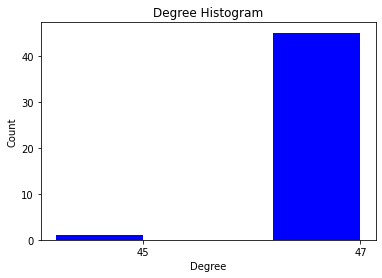

In [133]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

In [134]:
tf.vocabulary_

{'qe': 1940,
 'obj': 1646,
 'endobj': 768,
 'stream': 2340,
 'endstream': 770,
 'alabama': 76,
 'emergency': 751,
 'weather': 2654,
 'august': 171,
 'pm': 1808,
 'typepage': 2536,
 'management': 1442,
 'fema': 877,
 'state': 2316,
 'cdefghijstuvwxyzcdefghijstuvwxyz': 310,
 'plan': 1796,
 'cdt': 311,
 'assistance': 156,
 'extgstatefontprocsetpdftextrotate': 847,
 'ready': 1974,
 'disaster': 632,
 'mitigation': 1529,
 'public': 1933,
 'jp': 1280,
 'report': 2038,
 'county': 487,
 'agency': 59,
 'program': 1897,
 'ke': 1298,
 'pk': 1794,
 'heat': 1064,
 'al': 75,
 'ema': 741,
 'if': 1154,
 'email': 743,
 'am': 91,
 'severe': 2225,
 'go': 1010,
 'jz': 1294,
 'issued': 1254,
 'rbr': 1969,
 'aqaqbrbr': 129,
 'storm': 2334,
 'jfif': 1269,
 'aqaqb': 128,
 'local': 1406,
 'jh': 1270,
 'preparedness': 1847,
 'business': 265,
 'kgbybgnptutcrbkstq': 1303,
 'cqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq': 497,
 'resources': 2069,
 'office': 1661,
 'hazard': 1053,
 'extreme': 850,
 'services'

In [135]:
idf = tf.idf_
print(dict(zip(txt_fitted.get_feature_names(), idf)))

{'ab': 4.828641396489095, 'abbott': 4.828641396489095, 'abbottposted': 4.828641396489095, 'abduction': 4.828641396489095, 'able': 4.828641396489095, 'aboutnews': 4.828641396489095, 'abuse': 4.13549421592915, 'academy': 4.13549421592915, 'acadis': 4.828641396489095, 'access': 1.461345566502621, 'accesscouncils': 4.828641396489095, 'accessibility': 1.784118958765672, 'accessibilityprivacy': 4.828641396489095, 'accessible': 3.7300291078209855, 'accident': 4.828641396489095, 'accommodations': 4.828641396489095, 'according': 4.828641396489095, 'account': 3.03688192726104, 'accreditation': 4.828641396489095, 'accurate': 4.828641396489095, 'acic': 4.828641396489095, 'acres': 4.828641396489095, 'acrescontainment': 4.828641396489095, 'across': 3.2192034840549946, 'act': 2.0560526742493135, 'action': 3.4423470353692043, 'actions': 3.7300291078209855, 'activated': 4.828641396489095, 'activation': 4.13549421592915, 'active': 3.03688192726104, 'activities': 3.4423470353692043, 'activity': 3.2192034

/Users/rkfische/Library/Python/3.10/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [136]:
# get feature names
feature_names = np.array(tf.get_feature_names())
sorted_by_idf = np.argsort(tf.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['services' 'emergency' 'contact' 'management' 'state' 'public'
 'resources' 'not' 'program' 'department']

Features with highest idf:
['hr' 'hq' 'hpai' 'howto' 'housestate' 'houses' 'households' 'hour'
 'hurricanes' 'zt']


In [137]:
new1 = tf.transform(docs)

# find maximum value for each of the features over all of dataset:
max_val = new1.max(axis=0).toarray().ravel()

#sort weights from smallest to biggest and extract their indices 
sort_by_tfidf = max_val.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sort_by_tfidf[:10]]))

print("\nFeatures with highest tfidf: \n{}".format(
      feature_names[sort_by_tfidf[-10:]]))

Features with lowest tfidf:
['services' 'emergency' 'contact' 'management' 'state' 'public'
 'resources' 'not' 'program' 'department']

Features with highest tfidf: 
['hr' 'hq' 'hpai' 'howto' 'housestate' 'houses' 'households' 'hour'
 'hurricanes' 'zt']


## change

In [138]:
# convert the text to a tf-idf weighted term-document matrix
vectorizer = TfidfVectorizer(max_features=3000, min_df=4, stop_words='english')
X = vectorizer.fit_transform(docs)
idx_to_word = np.array(vectorizer.get_feature_names())

In [140]:
# apply NMF
nmf = NMF(n_components=20, solver="mu")
W = nmf.fit_transform(X)
H = nmf.components_

In [141]:
for i, topic in enumerate(H):
 
    print("Topic {}: {}".format(i + 1, ", ".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: management, report, mitigation, national, recovery, response, planning, local, federal, operations
Topic 2: employees, quality, disabilities, veterans, environmental, energy, professional, care, housing, families
Topic 3: providers, collect, responsible, regarding, provided, cookies, collected, users, purposes, shall
Topic 4: stream, endstream, council, endobj, obj, board, design, portal, adobe, structparents
Topic 5: id, technical, procedures, committee, materials, section, communities, webeoc, threat, tribal
Topic 6: june, declaration, major, september, october, cases, march, december, november, february
Topic 7: mobile, app, cookies, blog, relations, customer, life, case, exercises, join
Topic 8: tools, severe, emergencies, follow, tornadoes, stream, drought, endstream, obj, endobj
Topic 9: safe, hurricane, force, links, severe, courses, storm, line, task, power
Topic 10: highway, questions, mission, annual, dps, criminal, conference, prevention, history, crime
Topic 11: ac

In [142]:
print(G2['education'])

{3: {'weight': 0.036634955131550725}, 6: {'weight': 0.038326475160334335}, 7: {'weight': 0.039875653702112455}, 9: {'weight': 0.03882679342038633}, 13: {'weight': 0.03864569425623752}, 14: {'weight': 0.0361299560900764}, 19: {'weight': 0.03788675787843229}, 20: {'weight': 0.03885122471079324}, 21: {'weight': 0.0375781171405732}, 25: {'weight': 0.04231491044603095}, 27: {'weight': 0.045067801828677714}, 30: {'weight': 0.041246788267802384}, 36: {'weight': 0.038683301364118475}, 39: {'weight': 0.03928270837773986}, 42: {'weight': 0.040192849821405786}, 44: {'weight': 0.04074616269887409}}


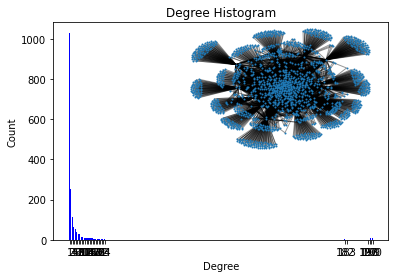

In [143]:
G= G2

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
#Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=1)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.show()

In [144]:
print(nx.info(G2))

Graph with 1751 nodes and 4681 edges


<ipython-input-144-aab6ddcbf3bc>:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G2))
